In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'deepsig_custom_v2_dft'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = dataset_df[dft_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 2, 128)
[2, 128]


In [16]:
model = neural_networks.custom_deepsig_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
dense (Dense)                (None, 2, 256)            9472      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             18450     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4864  

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
151/151 [==============================] - 16s 11ms/step - loss: 2.2293 - val_loss: 1.9338
Epoch 2/100
151/151 [==============================] - 1s 7ms/step - loss: 1.8926 - val_loss: 1.8187
Epoch 3/100
151/151 [==============================] - 1s 7ms/step - loss: 1.7946 - val_loss: 1.7653
Epoch 4/100
151/151 [==============================] - 1s 7ms/step - loss: 1.7331 - val_loss: 1.7190
Epoch 5/100
151/151 [==============================] - 1s 7ms/step - loss: 1.6868 - val_loss: 1.6703
Epoch 6/100
151/151 [==============================] - 1s 7ms/step - loss: 1.6313 - val_loss: 1.6271
Epoch 7/100
151/151 [==============================] - 1s 7ms/step - loss: 1.5906 - val_loss: 1.6064
Epoch 8/100
151/151 [==============================] - 1s 7ms/step - loss: 1.5704 - val_loss: 1.5894
Epoch 9/100
151/151 [==============================] - 1s 7ms/step - loss: 1.5457 - val_loss: 1.5765
Epoch 10/100
151/151 [==============================] - 1s 7ms/step - loss: 1.5303 - val_

# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

65/65 [==============================] - 0s 3ms/step - loss: 1.4647
1.4647245407104492


## Loss

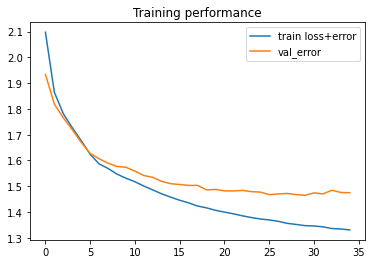

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

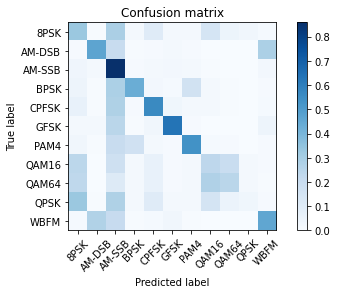

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09346642468239565
Overall Accuracy:  0.09241920869827847
Overall Accuracy:  0.0978685079555689
Overall Accuracy:  0.11942532175995212
Overall Accuracy:  0.15361714796070258
Overall Accuracy:  0.20554202192448234
Overall Accuracy:  0.2982456140350877
Overall Accuracy:  0.35126101488909145
Overall Accuracy:  0.4057883629785951
Overall Accuracy:  0.5353012781497261
Overall Accuracy:  0.6272445820433437
Overall Accuracy:  0.6508127633955448
Overall Accuracy:  0.6535603715170278
Overall Accuracy:  0.6399877338239803
Overall Accuracy:  0.645468509984639
Overall Accuracy:  0.6417775090689238
Overall Accuracy:  0.6248861911987861
Overall Accuracy:  0.643154761904762
Overall Accuracy:  0.6314208471012316
Overall Accuracy:  0.6281269066503966


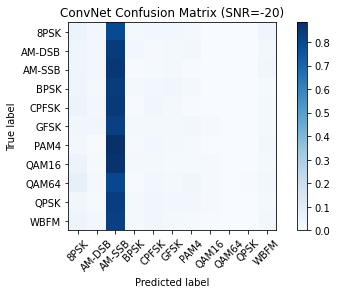

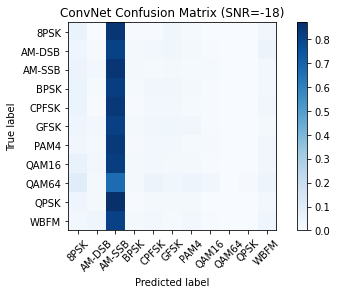

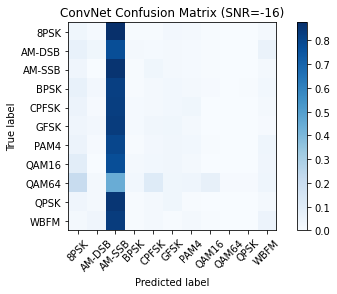

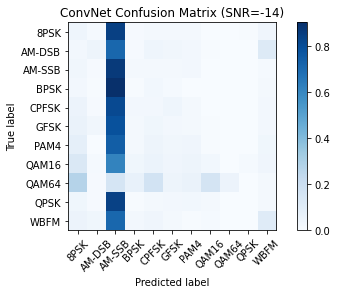

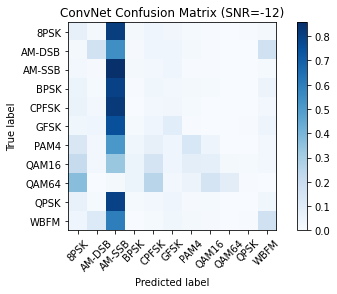

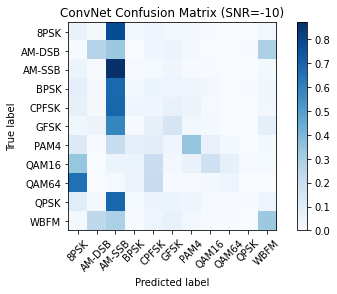

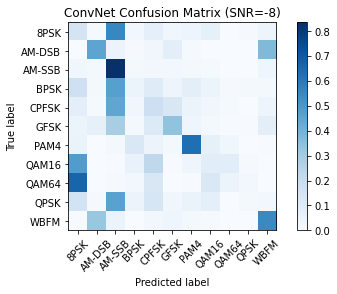

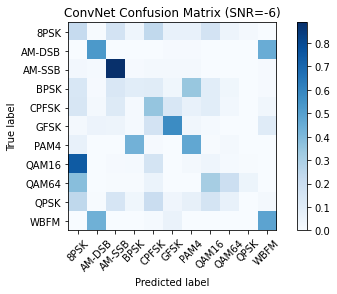

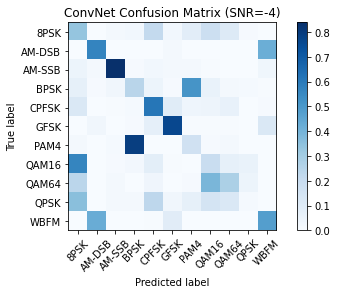

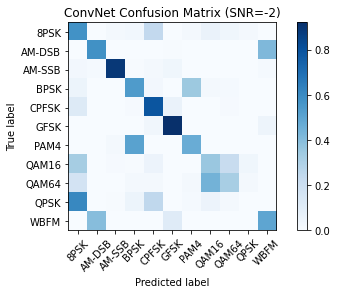

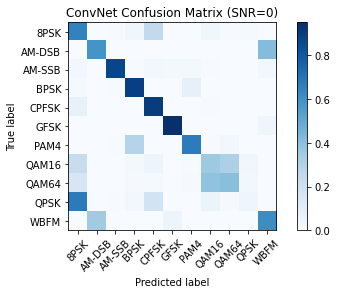

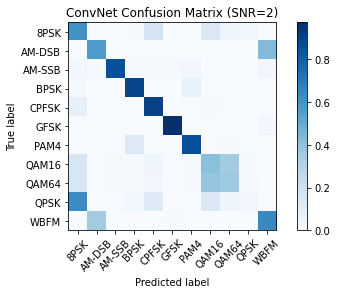

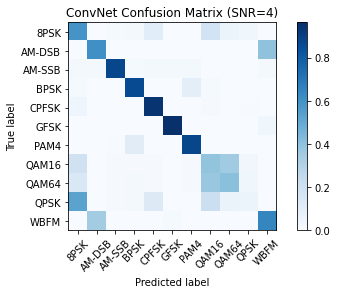

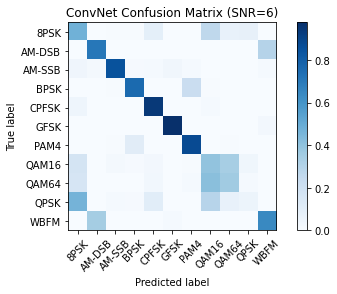

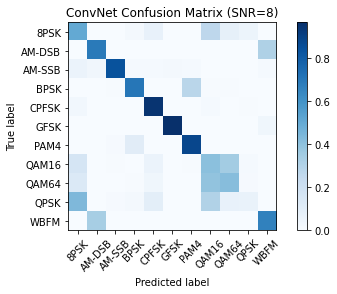

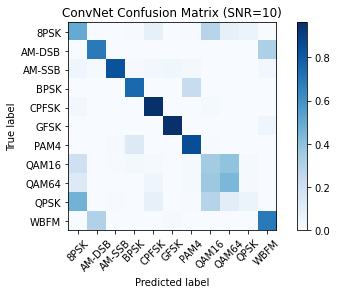

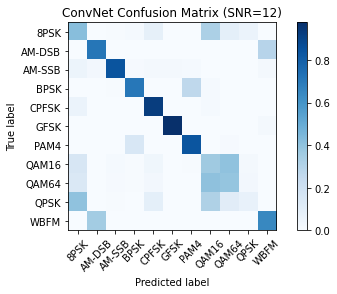

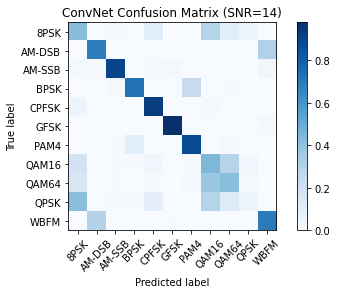

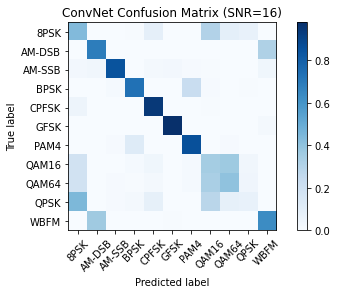

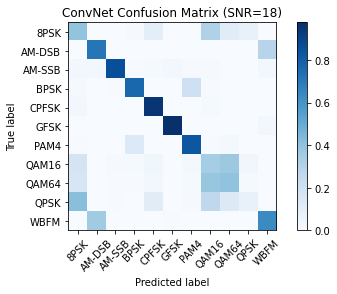

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,11,15,20,29,35,40,53,62,65,65,63,64,64,62,64,63,62


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

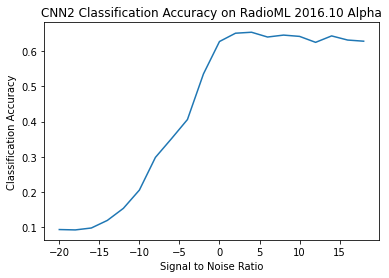

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")